In [1]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A function for constructing a label vector and loading the RSSI values from the excel files into a numpy array. The dataset consists
# of 1380 examples and each example has 9 features (each one corresponding to each of the 9 detectors) whose values are obtained by
# taking the mean value of 50 consecutive RSSI values.

def data_prep(path):
    X = np.zeros([1380, 9])
    y = []
    class_start = 0

    for n in tqdm([0, 1, 3, 5, 7, 9]):
        folder_path = path + str(n) + '_O'
        dataframes = []

        for filename in os.listdir(folder_path):
            if filename.endswith('.xlsx'):
                file_path = os.path.join(folder_path, filename)
                df = pd.read_excel(file_path)
                df=df.drop(["time"], axis=1)
                dataframes.append(df)

        detector = 0
        for dt in dataframes:
            whole_table = dt.to_numpy()
            sample_start = 0
            for i in range(class_start, class_start + 230):
                if(detector == 0):
                    y.append(n)

                X[i][detector] = np.mean(whole_table[sample_start : sample_start + 50])

                if (n == 0):
                    sample_start = np.random.randint(210000)
                else:
                    sample_start += 50

            detector += 1

        class_start += 230

    y = np.array(y)
    
    return X, y

In [2]:
class NeuralNetwork:
    def __init__(self, features, classes, learning_rate = 0.01, n_epochs=2000, b_size = 30):
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = b_size
        self.w1 = 0.1*np.random.randn(100, features)
        self.b1 = 0.1*np.random.randn(1, 100)
        self.w2 = 0.1*np.random.randn(classes, 100)
        self.b2 = 0.1*np.random.randn(1, classes)
    
    def _ReLU(self, Z):
        return np.maximum(0, Z)
    
    def _dReLU(self, Z):
        return Z > 0
    
    def _softmax(self, Z):
        return np.exp(Z)/np.sum(np.exp(Z), axis=1, keepdims=True)
    
    def _make_hot(self, y):
        Y = np.zeros([len(y), max(y) + 1])
        Y[np.arange(len(y)), y] = 1
        return Y
        
    def _forward_prop(self, X):
        Z1 = np.dot(X, self.w1.T) + self.b1
        A1 = self._ReLU(Z1)
        Z2 = np.dot(A1, self.w2.T) + self.b2
        A2 = self._softmax(Z2)
        return Z1, A1, Z2, A2
    
    def _back_prop(self, Z1, A1, Z2, A2, X, Y):
        n = len(Y)
        dZ2 = A2 - Y
        dw2 = 1/n * np.dot(dZ2.T, A1)
        db2 = 1/n * np.sum(dZ2, axis = 0)
        dZ1 = np.dot(dZ2, self.w2)*self._dReLU(Z1)
        dw1 = 1/n * np.dot(dZ1.T, X)
        db1 = 1/n * np.sum(dZ1, axis = 0)
        return dw1, db1, dw2, db2
    
    def _update_params(self, dw1, db1, dw2, db2):
        self.w1 -= self.lr*dw1
        self.b1 -= self.lr*db1
        self.w2 -= self.lr*dw2
        self.b2 -= self.lr*db2
    
    def fit(self, X, y):
        Y = self._make_hot(y)
        
        n_samples = X.shape[0]
        n_batches = n_samples // self.batch_size
        
        for epoch in range(self.n_epochs):
            shuffled_indexes = np.random.permutation(n_samples)
            X = X[shuffled_indexes]
            Y = Y[shuffled_indexes]
            
            for batch in range(n_batches):
                start = batch * self.batch_size
                end = start + self.batch_size
                X_batch = X[start:end]
                Y_batch = Y[start:end]
                
                Z1, A1, Z2, A2 = self._forward_prop(X_batch)
                dw1, db1, dw2, db2 = self._back_prop(Z1, A1, Z2, A2, X_batch, Y_batch)
                self._update_params(dw1, db1, dw2, db2)
    
    def predict(self, X):
        Z1, A1, Z2, A2 = self._forward_prop(X)
        return np.argmax(A2, axis=1) 
    
    def _calc_loss(self, Y, Y_hat):
        epsilon = 1e-15  # Small value to avoid division by zero
        Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)  # Clip probabilities to avoid log(0)
        loss = -np.sum(Y * np.log(Y_hat)) / len(Y)
        return loss
    
    def calc_accuracy(self, y_hat, y):
        correct_predictions = sum(p == a for p, a in zip(y_hat, y))
        total_predictions = len(y_hat)
    
        accuracy = correct_predictions / total_predictions
        return accuracy

In [3]:
class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        # covariance
        cov = np.cov(X, rowvar = False)

        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, idxs]

        self.components = eigenvectors[:, :self.n_components]

    def transform(self, X):
        # projects data
        X = X - self.mean
        return np.dot(X, self.components)

In [7]:
X, y = data_prep("C:/Users/Nikola/Downloads/19_10_2022/") # Argument is the path to the folder in which the excel files are located

def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    standardized_X = (X - mean) / std
    return standardized_X

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:19<00:00, 13.17s/it]


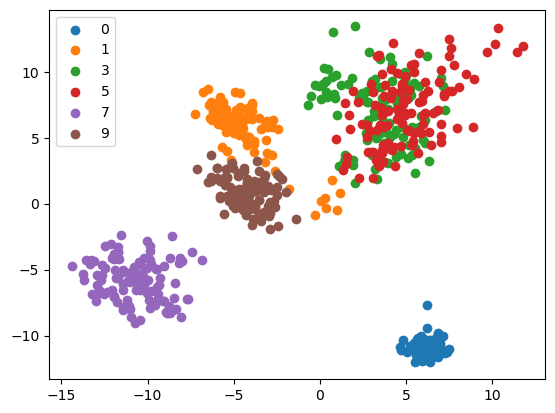

In [8]:
# Using PCA to visualize the dataset

LA = PCA(n_components=2)

LA.fit(X)
X_transformed = LA.transform(X)

fig,ax = plt.subplots()

for i in range(0,1380, 230):
    ax.scatter(X_transformed[i:i+115, 1], X_transformed[i:i+115, 0], label=y[i])
    
ax.legend()
plt.show()

In [10]:
X = standardize(X)

shuffled_indexes = np.random.permutation(len(X))
X = X[shuffled_indexes]
y = y[shuffled_indexes]
      
# Performance of the neural net is evaluated using k-fold cross-validation for k = 20 and k = 4.

y_twenty = np.split(y, 20)
K_twenty = np.split(X, 20)

y_four = np.split(y, 4)
K_four = np.split(X, 4)

In [11]:
LA = NeuralNetwork(9, 10) # Arguments define the number of features a dataset has and the number of classes for classification

acc = []
for k in range(20):
    for i in range(20):
        if i != k:
            LA.fit(K_twenty[i], y_twenty[i])
    
    y_pred = LA.predict(K_twenty[k])
    acc += [LA.calc_accuracy(y_pred, y_twenty[k])]
    print(acc[k])

print(f"Test accuracy: {np.mean(acc):.2f}")

0.9420289855072463
0.9420289855072463
0.9420289855072463
0.927536231884058
0.9565217391304348
0.9855072463768116
0.9565217391304348
0.9710144927536232
0.9855072463768116
0.9710144927536232
0.9710144927536232
0.9710144927536232
0.9855072463768116
0.9710144927536232
1.0
0.9855072463768116
0.9855072463768116
1.0
0.9855072463768116
0.9855072463768116
Test accuracy: 0.97


In [12]:
LA1 = NeuralNetwork(9, 10)

acc = []
for k in range(4):
    for i in range(4):
        if i != k:
            LA1.fit(K_four[i], y_four[i])
    
    y_pred = LA1.predict(K_four[k])
    acc += [LA1.calc_accuracy(y_pred, y_four[k])]
    print(acc[k])

print(f"Test accuracy: {np.mean(acc):.2f}")

0.9420289855072463
0.9565217391304348
0.9710144927536232
0.9739130434782609
Test accuracy: 0.96
